<a href="https://colab.research.google.com/github/Hamza11222/vision-Transformers-on-insect-dataset/blob/main/vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/insect.zip' -d  '/content/drive/My Drive/insect'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/My Drive/insect/classification/val/29/23668.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23674.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23687.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23689.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23690.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23699.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23704.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23707.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23712.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23716.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23745.jpg  
  inflating: /content/drive/My Drive/insect/classification/val/29/23746.jpg  
  inflating: 

In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 5.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from textwrap import wrap

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A
from albumentations.pytorch.transforms import ToTensor

import timm

In [ ]:
f = open('/content/drive/My Drive/insect/classes.txt')
label = []
name = []
for line in f.readlines():
    label.append(int(line.split()[0]))
    name.append(' '.join(line.split()[1:]))
classes = pd.DataFrame([label, name]).T
classes.columns = ['label','name']
classes

label                        name
0       1            rice leaf roller
1       2       rice leaf caterpillar
2       3           paddy stem maggot
3       4          asiatic rice borer
4       5           yellow rice borer
..    ...                         ...
97     98        Chlumetia transversa
98     99  Mango flat beak leafhopper
99    100  Rhytidodera bowrinii white
100   101       Sternochetus frigidus
101   102                Cicadellidae

[102 rows x 2 columns]

In [ ]:
train_df = pd.read_csv('/content/drive/My Drive/insect/train.txt',sep=' ',header=None, engine='python')
train_df.columns = ['image_path','label']

test_df = pd.read_csv('/content/drive/My Drive/insect/test.txt',sep=' ',header=None, engine='python')
test_df.columns = ['image_path','label']

val_df = pd.read_csv('/content/drive/My Drive/insect/val.txt',sep=' ',header=None, engine='python')
val_df.columns = ['image_path','label']

train_df.head()

image_path  label
0  00002.jpg      0
1  00003.jpg      0
2  00005.jpg      0
3  00006.jpg      0
4  00008.jpg      0

In [ ]:
TRAIN_DIR = '/content/drive/My Drive/insect/classification/train'
TEST_DIR = '/content/drive/My Drive/insect/classification/test'
VAL_DIR = '/content/drive/My Drive/insect/classification/val'
LR = 2e-5
BATCH_SIZE = 8
EPOCH = 2

device = torch.device('cuda')

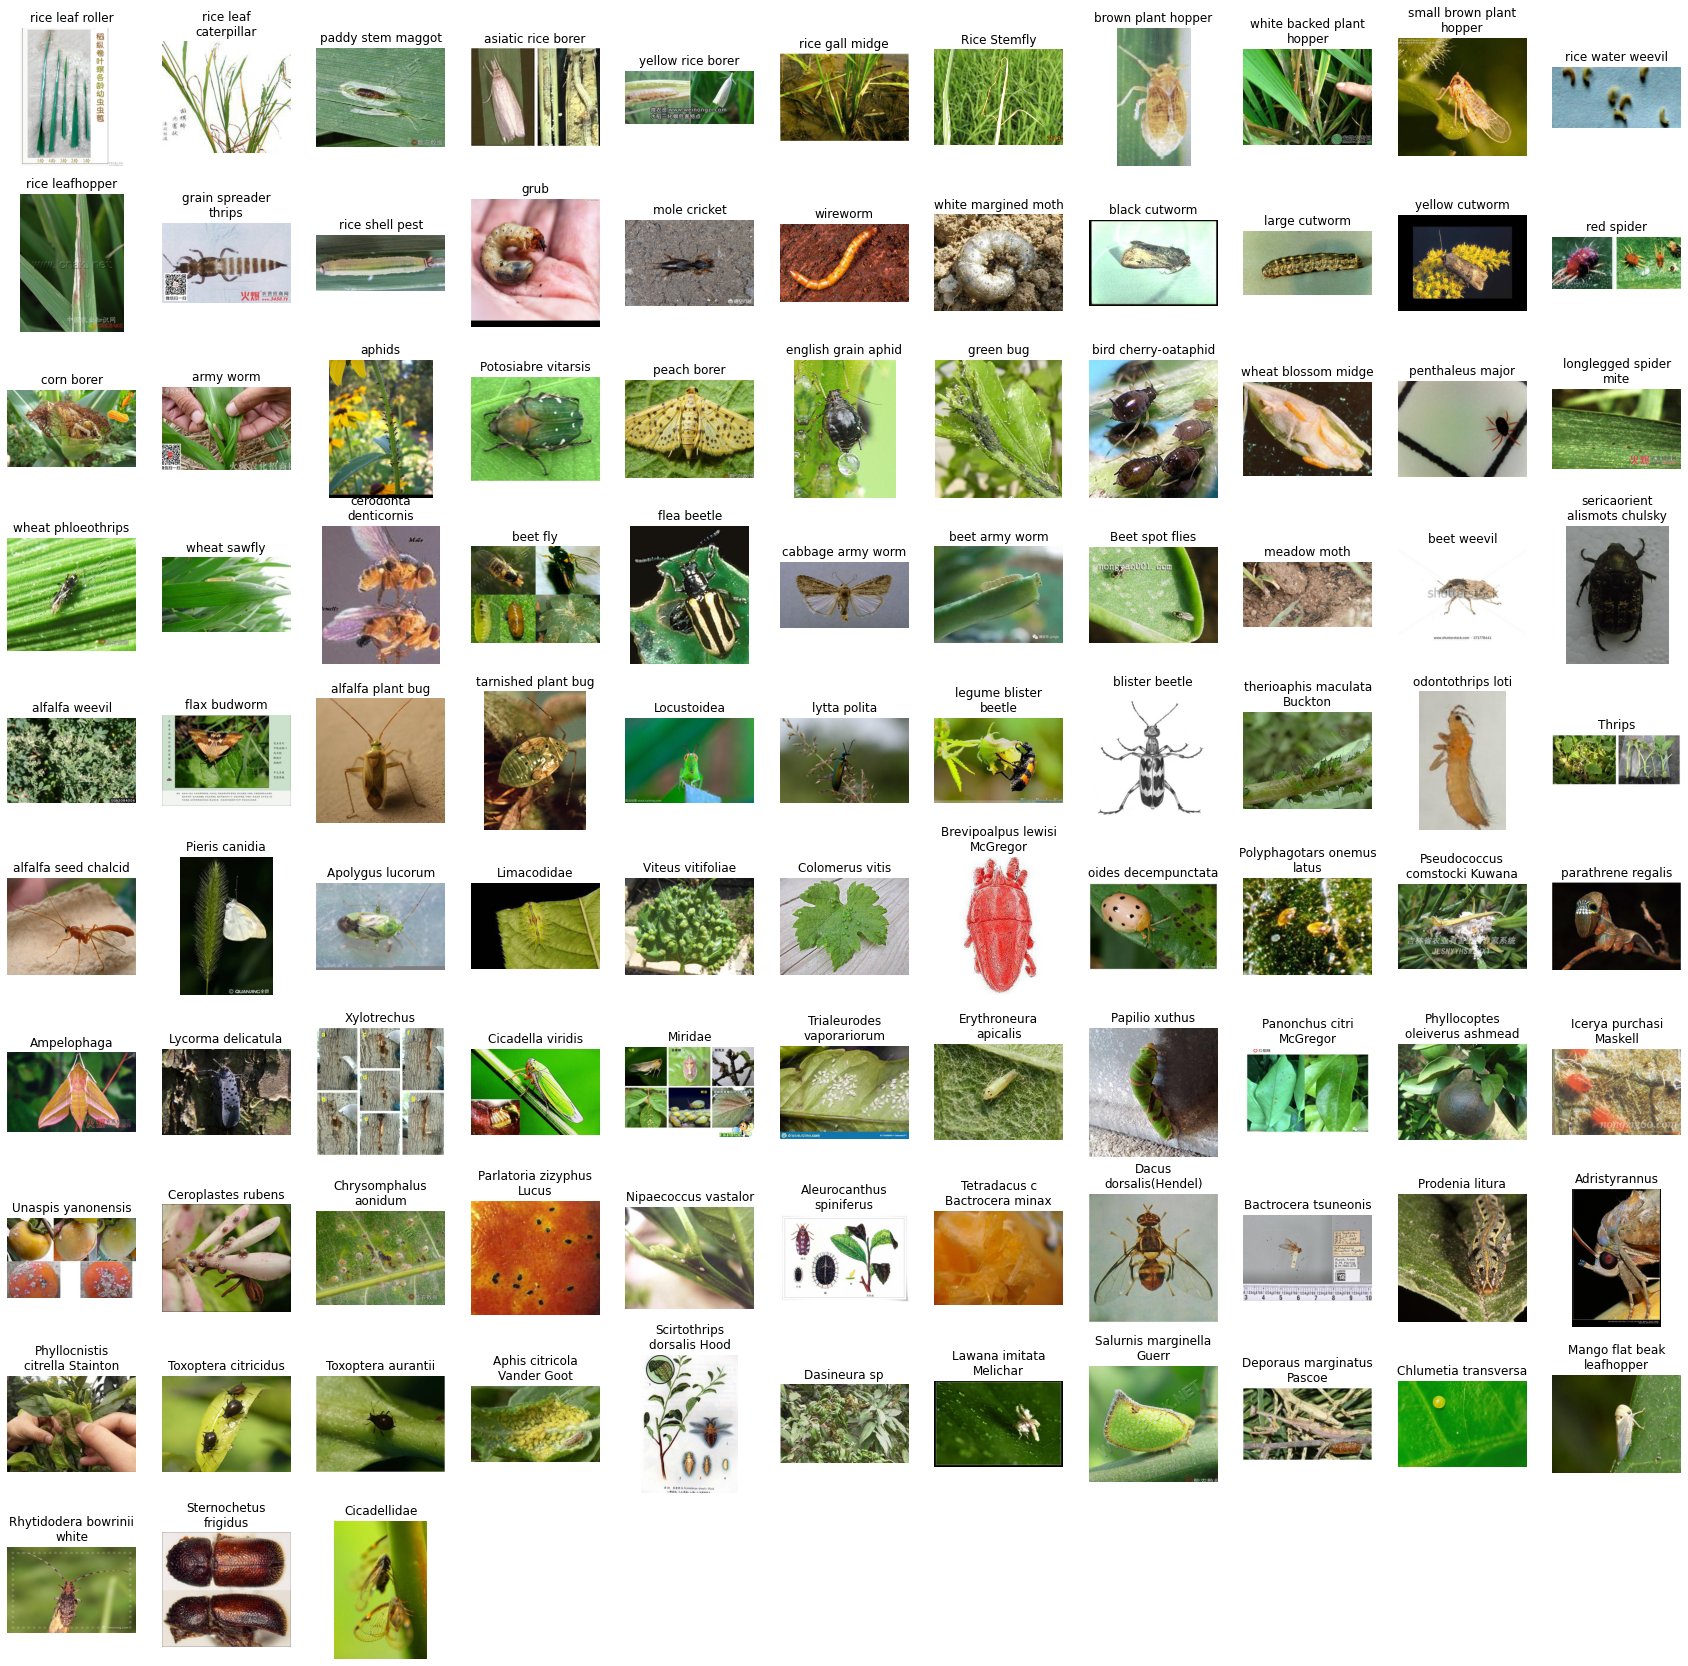

In [ ]:
fig, axs = plt.subplots(10,11,figsize=(30,30))
images = []
for i in classes.label:
    random_img = random.choice(train_df[train_df.label==i-1].image_path.values)
    label = classes.name[i-1]
    img = plt.imread(os.path.join(TRAIN_DIR,str(i-1),random_img))
    images.append(img)

[ax.imshow(image) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(label,20))) for label,ax in zip(list(classes.name),axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()

In [ ]:
class InsectModel(nn.Module):
    def __init__(self,num_classes):
        super(InsectModel, self).__init__()
        self.num_classes = num_classes
        self.model = timm.create_model('vit_base_patch16_224',pretrained=True,num_classes=num_classes)
    def forward(self, image):
        return self.model(image)

In [ ]:
def train_transform():
    return A.Compose([
        A.HorizontalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(),
        A.Resize(224, 224),
        ToTensorV2()])

def valid_transform():
    return A.Compose([
        A.Resize(224,224),
        ToTensorV2()])

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
class InsectDataset(Dataset):
    def __init__(self, image, image_dir, transforms=None):
        self.image_info = image
        self.transforms = transforms
        self.imgdir = image_dir
    def __len__(self):
        return self.image_info.shape[0]
    def __getitem__(self, index):
        image_info = self.image_info[index]
        image = cv2.imread(os.path.join(self.imgdir,str(image_info[1]),image_info[0]),cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.
        
        if self.transforms is not None:
            image = self.transforms(image = image)['image']
        
        label = image_info[1]
        
        image = torch.as_tensor(image, dtype=torch.float32)
        label = torch.as_tensor(label, dtype=torch.long)
        return image, label

In [ ]:
train_dataset = InsectDataset(image=train_df.values, 
                              image_dir=TRAIN_DIR, 
                              transforms=train_transform())
train_data_loader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=2)
val_dataset = InsectDataset(image=val_df.values,
                            image_dir=VAL_DIR,
                            transforms=valid_transform())
val_data_loader = DataLoader(val_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=2)

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss = 0
        self.correct = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, loss,correct, n=1):
        self.loss = loss
        self.correct += correct
        self.sum += loss * n
        self.count += n
        
        self.avg = self.sum / self.count
        self.acc = self.correct / self.count
        
class Accuracy(object):
    def __init__(self):
        self.reset

In [ ]:
def train_fn(data_loader, model, criterion, device, optimizer, epoch):
    model.train()
    criterion.train()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, (images, labels) in enumerate(tk0):
        images = images.to(device, non_blocking = True).float()
        labels = labels.to(device, non_blocking = True).long()
    
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = output.softmax(1).argmax(1)
        correct = (preds == labels).sum().item()
        
        summary.update(loss.item(),correct, BATCH_SIZE)
        tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary

def eval_fn(data_loader, model, criterion, device, epoch):
    model.eval()
    criterion.eval()
    
    summary = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader))
    with torch.no_grad():
        for step, (images, labels) in enumerate(tk0):
            images = images.to(device, non_blocking = True).float()
            labels = labels.to(device, non_blocking = True).long()
            
            output = model(images)
            loss = criterion(output, labels)
            
            preds = output.softmax(1).argmax(1)
            correct = (preds == labels).sum().item()
            
            summary.update(loss.item(), correct, BATCH_SIZE)
            tk0.set_postfix(loss=summary.avg, acc=summary.acc, epoch=epoch+1)
    return summary
    

In [ ]:
os.environ['WANDB_CONSOLE'] = 'off'

def run():
    model = InsectModel(num_classes=102)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    best_loss = 10**5
    for epoch in range(0, EPOCH):
        train_loss = train_fn(train_data_loader, model, criterion, device, optimizer, epoch)
        val_loss = eval_fn(val_data_loader, model, criterion, device, epoch)
        if val_loss.avg < best_loss:
            best_loss = val_loss.avg
            torch.save(model.state_dict(), f'vit_best.pth')
        print(f'Epoch {epoch+1+0:03}: | Train Loss: {train_loss.avg:.5f} | Val Loss: {val_loss.avg:.5f}')

In [ ]:
run()

100%|██████████| 939/939 [01:23<00:00, 11.21it/s, acc=0.674, epoch=1, loss=1.16]


Epoch 001: | Train Loss: 1.52518 | Val Loss: 1.15844


100%|██████████| 939/939 [01:07<00:00, 13.98it/s, acc=0.699, epoch=2, loss=1.08]


Epoch 002: | Train Loss: 0.90444 | Val Loss: 1.07740


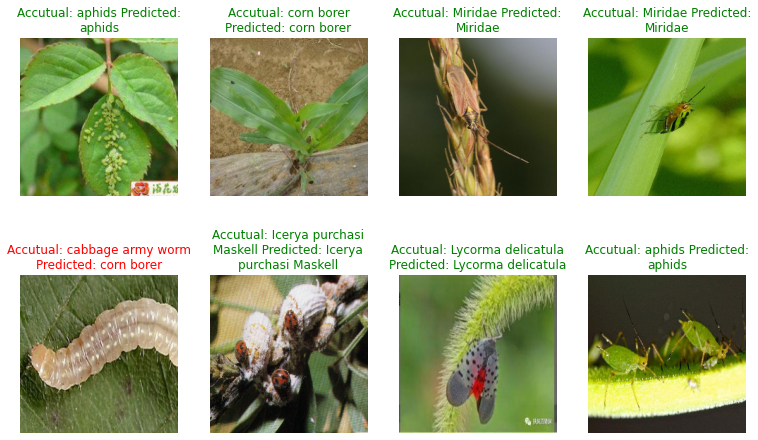

In [ ]:
model = InsectModel(num_classes=102)
model.load_state_dict(torch.load("./vit_best.pth"))
images, labels = next(iter(val_data_loader))
preds = model(images).softmax(1).argmax(1)

fig, axs = plt.subplots(2,4,figsize=(13,8))
[ax.imshow(image.permute((1,2,0))) for image,ax in zip(images,axs.ravel())]
[ax.set_title("\n".join(wrap(f'Accutual: {classes.name[label.item()]} Predicted: {classes.name[pred.item()]}',30)),color = 'g' if label.item()==pred.item() else 'r') for label,pred,ax in zip(labels,preds,axs.ravel())]
[ax.set_axis_off() for ax in axs.ravel()]
plt.show()